In [115]:
import pandas as pd
import re
import string
import nltk
import numpy as np

In [28]:
articles = pd.read_csv('csv/trial3.csv')

data = pd.read_excel('xlsx/LM.xlsx','Negative', header=None)
data = data[0]
negList = data.tolist()
negList = [x.lower() for x in negList]

data = pd.read_excel('xlsx/LM.xlsx','Positive', header=None)
data = data[0]
posList = data.tolist()
posList = [x.lower() for x in posList]

In [29]:
def preprocess( s ):
    # Convert text to upper case
    s = s.lower()
    # Connect words that have been cut off by the end of the page
    s = s.replace('-\n', '')
    # Remove numbers
    s = re.sub(r'\d+', '', s)
    s = s.strip()
    # use regex to remove punctuation
    s = re.sub(r'[^\w\s]','',s)
    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words("english"))
    from nltk.tokenize import word_tokenize
    # Tokenise
    tokens = word_tokenize(s)
    s = [i for i in tokens if not i in stop_words]
    return s

In [36]:
def getFreqScore( article ):
    
    posCount = 0
    negCount = 0
    for word in article:
        if word in negList:
            negCount += 1
        if word in posList:
            posCount += 1
    
    if posCount + negCount == 0:
        return 0
    
    return (posCount - negCount) / (posCount + negCount)

In [31]:
articles['score'] = articles.apply(lambda row: getFreqScore(preprocess(str(row.text))), axis=1)

display(articles)

,title,date,text,score
0,"Remember Brexit? It’s back and, yes, there’s a...",2020-06-13,So Brexit is back in the news? Yes. The UK lef...,-0.692308
1,Aviation authority reports 83% decline in flig...,2020-06-12,The Irish Aviation Authority (IAA) has reporte...,-0.333333
2,Consumer lending dropped to record low of €64m...,2020-06-12,Consumer lending in the Irish economy dropped ...,-0.750000
3,Hard learned lessons in leading a business thr...,2020-06-12,"Roisin Hennerty Managing Director, Ornua Foods...",-0.037037
4,Second Covid-19 wave ‘would wipe out economic ...,2020-06-10,A second wave of Covid-19 would wipe out any c...,-0.882353
...,...,...,...,...
10491,Ireland quickly closing the gap on its EU part...,1996-01-06,AT the end of last week's article on the Irish...,-0.250000
10492,Bulls can thunder on this year,1996-01-06,THE year just ended has been one of by the all...,-0.224490
10493,"Bonds, savings certs still good bets",1996-01-05,"IF the political pundits are correct, then 199...",0.647059
10494,Creating Employment,1996-01-03,By any yardstick the figures on job creation f...,-0.083333


In [32]:
articles = articles.drop(articles[articles.date == "s//0-00-00"].index)
articles["date"] = pd.to_datetime(articles["date"], format="%Y-%m-%d")
articles = articles.set_index([pd.DatetimeIndex(articles["date"])])
articles = articles.sort_index(axis=0, ascending=True)
articles = articles.drop(columns = "date")

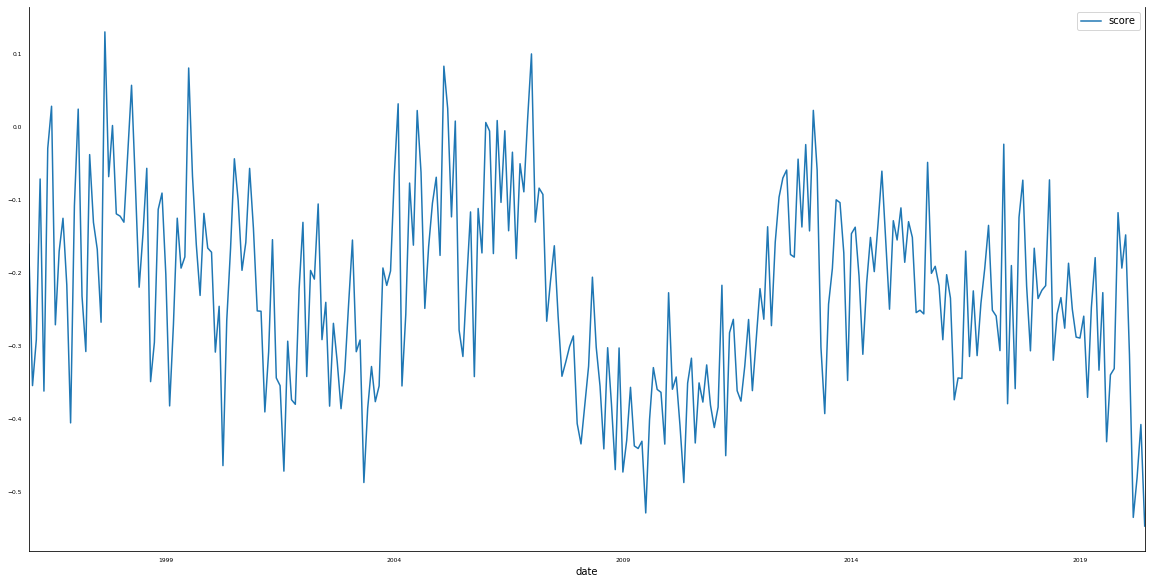

In [207]:
t = lambda s : pd.Timestamp(s)

monthlyCount = articles.resample("M")
meanScore = monthlyCount.mean()
ax = meanScore.plot(figsize=(20, 10))
# Decorations
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

### Stationarity
We can identify a normal distribution in the histogram plot of our data. This implies that the time series is stationary.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2cc1ee50>]],
      dtype=object)

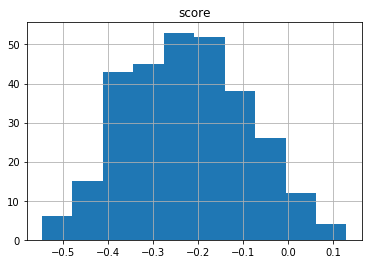

In [34]:
meanScore.hist()

### Augmented Dickey-Fuller test
We perform a hypthesis test that the time series is stationary. The null hypothesis is that the time series is not stationary, and the alternative is that it is. If our resulting p-value is >= 0.05 we can reject the null hypthesis. We can compare our ADF statistic to our 'critical values' to see the level of significance at which we can reject the null hypothesis.

Our results give an ADF statistic of -3.7, with a critical value of -3.4 for a 1% level of significance. Because our ADF < -3.4, we may reject the null hypothesis with a confidence of 99%.

In [35]:
from statsmodels.tsa.stattools import adfuller
import math

meanScore = meanScore.dropna()
result = adfuller(meanScore)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.648195
p-value: 0.004904
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


In [27]:
newArticles = pd.read_csv('csv/trial3.csv')
newArticles

,title,date,text
0,"Remember Brexit? It’s back and, yes, there’s a...",2020-06-13,So Brexit is back in the news? Yes. The UK lef...
1,Aviation authority reports 83% decline in flig...,2020-06-12,The Irish Aviation Authority (IAA) has reporte...
2,Consumer lending dropped to record low of €64m...,2020-06-12,Consumer lending in the Irish economy dropped ...
3,Hard learned lessons in leading a business thr...,2020-06-12,"Roisin Hennerty Managing Director, Ornua Foods..."
4,Second Covid-19 wave ‘would wipe out economic ...,2020-06-10,A second wave of Covid-19 would wipe out any c...
...,...,...,...
10491,Ireland quickly closing the gap on its EU part...,1996-01-06,AT the end of last week's article on the Irish...
10492,Bulls can thunder on this year,1996-01-06,THE year just ended has been one of by the all...
10493,"Bonds, savings certs still good bets",1996-01-05,"IF the political pundits are correct, then 199..."
10494,Creating Employment,1996-01-03,By any yardstick the figures on job creation f...


In [199]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
import re

def makeVaderDict( df ):
    sia = SentimentIntensityAnalyzer()
    
    negDict = {}
    for w in negList:
        negDict[w] = -2
        
    posDict = {}
    for w in posList:
        posDict[w] = 2
          
    sia.lexicon.update(negDict)
    sia.lexicon.update(posDict)
    
    wordCounts = {}
    classCounts = {'pos':0, 'neu':0, 'neg':0}
    n = 0
    
    textSeries = df['text']
    for i in range(len(textSeries)):
        articleText = textSeries[i]
        rx = r"\.(?=\S)"
        sentences = []
        if(isinstance(articleText, str)):
            articleText = re.sub(rx, ". ", articleText)
            sentences = sent_tokenize(articleText)
        for s in sentences:
            sent = sia.polarity_scores(s)
            
            words = word_tokenize(s)
            for w in words:
                if w in wordCounts:
                    wordCounts[w]['pos'] += sent['pos']
                    wordCounts[w]['neg'] += sent['neg']
                    wordCounts[w]['neu'] += sent['neu']
                else:
                    wordCounts[w] = {'pos':0,'neg':0,'neu':0}
            
            classCounts['pos'] += sent['pos']
            classCounts['neg'] += sent['neg']
            classCounts['neu'] += sent['neu']
            
            n += len(words)
    
    nonZeroWord = lambda w: sum(wordCounts[w].values()) != 0
    
    pwc = lambda w, c: wordCounts[w][c] / sum(wordCounts[w].values())
    pw = lambda w: sum(wordCounts[w].values()) / n
    pc = lambda c: classCounts[c] / sum(classCounts.values())
    PMI = lambda w, c: np.log(pwc(w,c) / pw(w) * pc(c))
    
    wordSentiments = {}
    
    for w in wordCounts:
        preWList = preprocess(w)
        if len(preWList) > 0:
            preW = preWList[0]
            if nonZeroWord(w):
                wordSentiments[preW] = PMI(w, 'pos') - PMI(w, 'neg')
            else:
                wordSentiments[preW] = 0
        
    return wordSentiments

In [200]:
articles2 = pd.read_csv('csv/trial3.csv')

wordSentiments = makeVaderDict(articles2)
len(wordSentiments)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars


71336

In [203]:
def getVaderScore( article ):
    score = 0
    for word in article:
        if word in wordSentiments:
            if(wordSentiments[word] > -4 and wordSentiments[word] < 4):
                score += wordSentiments[word]
    return score / len(article)

In [204]:
articles2['score'] = articles2.apply(lambda row: getVaderScore(preprocess(str(row.text))), axis=1)

In [205]:
articles2 = articles2.drop(articles2[articles2.date == "s//0-00-00"].index)
articles2["date"] = pd.to_datetime(articles2["date"], format="%Y-%m-%d")
articles2 = articles2.set_index([pd.DatetimeIndex(articles2["date"])])
articles2 = articles2.sort_index(axis=0, ascending=True)
articles2 = articles2.drop(columns = "date")

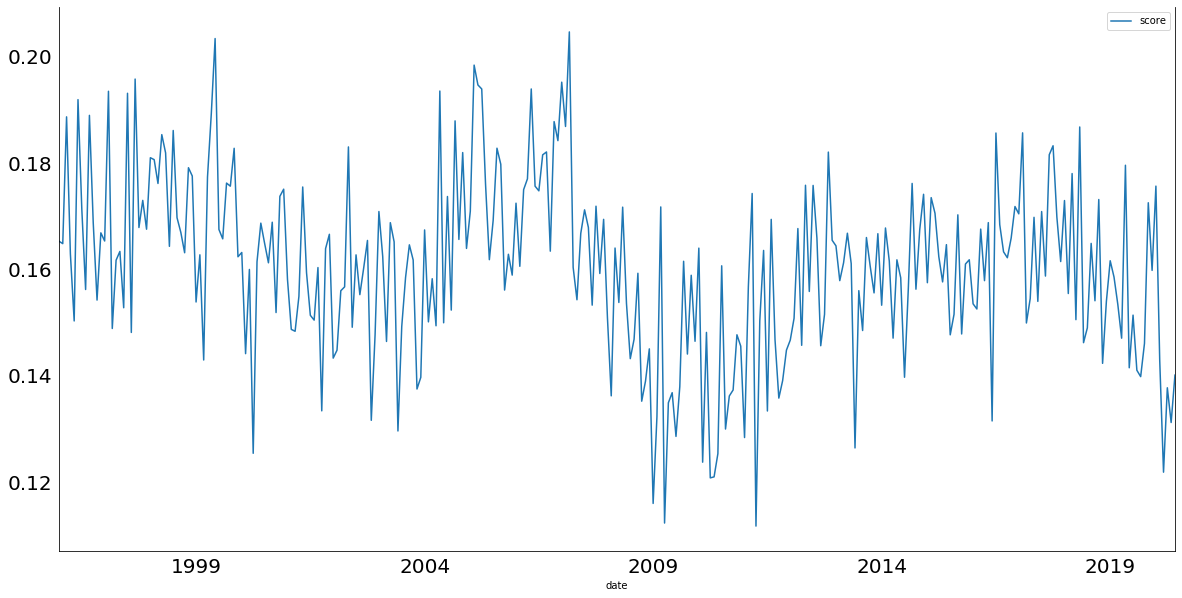

In [206]:
monthlyCount = articles2.resample("M")
meanScore = monthlyCount.mean()
ax = meanScore.plot(figsize=(20, 10))
# Decorations
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=20)